In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cauchy_simulations import CauchyLiquidityProfile, ModifiedCauchyLiquidityProfile, from_bps_tick

In [3]:
C = 10.0  # total liquidity parameter
GAMMA = 0.1  # scale parameter
MAX_TICK = 887272
TICK_SPACING = 10  # step size between ticks in arrays

In [4]:
clp = CauchyLiquidityProfile(c=C, gamma=GAMMA)

In [5]:
# should be c / (pi * gamma)
clp.at(0) == C / (np.pi * GAMMA)

True

In [6]:
# plot liquidity profile over ticks
bps_ticks = np.arange(start=-MAX_TICK, stop=MAX_TICK, step=TICK_SPACING)
log_ticks = from_bps_tick(bps_ticks)
liquidities = clp.at(log_ticks)

In [7]:
df = pd.DataFrame(data={'bps_ticks': bps_ticks, 'log_ticks': log_ticks, f'l(t) [c={C}, g={GAMMA}]': liquidities})
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]"
0,-887272,-88.722764,0.00004
1,-887262,-88.721764,0.00004
2,-887252,-88.720764,0.00004
3,-887242,-88.719764,0.00004
4,-887232,-88.718764,0.00004
...,...,...,...
177450,887228,88.718364,0.00004
177451,887238,88.719364,0.00004
177452,887248,88.720364,0.00004
177453,887258,88.721364,0.00004


<Axes: xlabel='bps_ticks'>

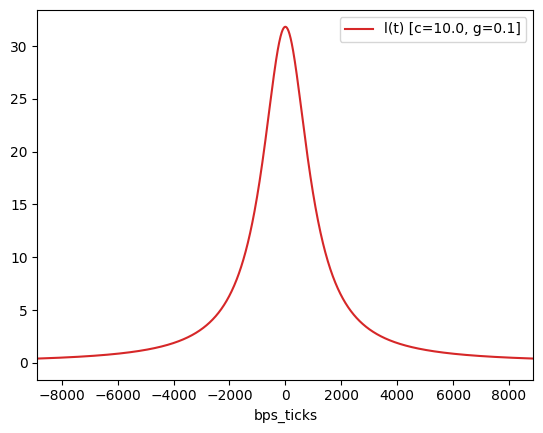

In [8]:
# plot +/- 60% 
df.plot(x='bps_ticks', y=f'l(t) [c={C}, g={GAMMA}]', xlim=(-MAX_TICK // 100, MAX_TICK // 100), color='C3')

In [9]:
# generate for more gammas
gammas = np.array([0.0125, 0.025, 0.05, 0.1, 0.2, 0.5, 1.0])

In [10]:
for g in gammas:
    df[f'l(t) [c={C}, g={g}]'] = CauchyLiquidityProfile(c=C, gamma=g).at(log_ticks)

In [11]:
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]","l(t) [c=10.0, g=0.0125]","l(t) [c=10.0, g=0.025]","l(t) [c=10.0, g=0.05]","l(t) [c=10.0, g=0.2]","l(t) [c=10.0, g=0.5]","l(t) [c=10.0, g=1.0]"
0,-887272,-88.722764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404
1,-887262,-88.721764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404
2,-887252,-88.720764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404
3,-887242,-88.719764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404
4,-887232,-88.718764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404
...,...,...,...,...,...,...,...,...,...
177450,887228,88.718364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404
177451,887238,88.719364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404
177452,887248,88.720364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404
177453,887258,88.721364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404


<Axes: xlabel='bps_ticks'>

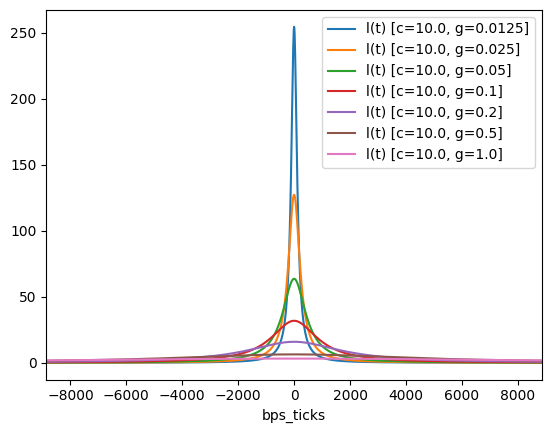

In [12]:
df.plot(x='bps_ticks', y=[f'l(t) [c={C}, g={g}]' for g in gammas], xlim=(-MAX_TICK // 100, MAX_TICK // 100))

<Axes: xlabel='bps_ticks'>

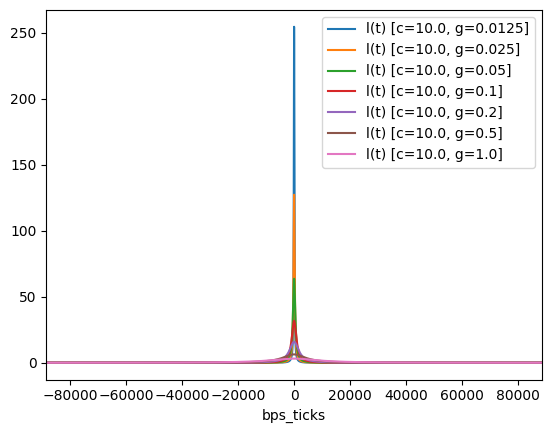

In [13]:
df.plot(x='bps_ticks', y=[f'l(t) [c={C}, g={g}]' for g in gammas], xlim=(-MAX_TICK // 10, MAX_TICK // 10))

In [14]:
# generate for more global liquidity constant values
cs = np.array([1.0, 2.5, 5.0, 10.0, 20.0, 40.0])

In [15]:
for c in cs:
    df[f'l(t) [c={c}, g={GAMMA}]'] = CauchyLiquidityProfile(c=c, gamma=GAMMA).at(log_ticks)

In [16]:
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]","l(t) [c=10.0, g=0.0125]","l(t) [c=10.0, g=0.025]","l(t) [c=10.0, g=0.05]","l(t) [c=10.0, g=0.2]","l(t) [c=10.0, g=0.5]","l(t) [c=10.0, g=1.0]","l(t) [c=1.0, g=0.1]","l(t) [c=2.5, g=0.1]","l(t) [c=5.0, g=0.1]","l(t) [c=20.0, g=0.1]","l(t) [c=40.0, g=0.1]"
0,-887272,-88.722764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162
1,-887262,-88.721764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162
2,-887252,-88.720764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162
3,-887242,-88.719764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162
4,-887232,-88.718764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177450,887228,88.718364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162
177451,887238,88.719364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162
177452,887248,88.720364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162
177453,887258,88.721364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,0.00001,0.00002,0.000081,0.000162


<Axes: xlabel='bps_ticks'>

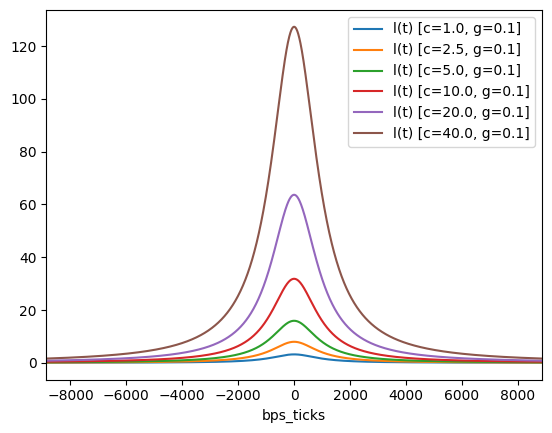

In [17]:
df.plot(x='bps_ticks', y=[f'l(t) [c={c}, g={GAMMA}]' for c in cs], xlim=(-MAX_TICK // 100, MAX_TICK // 100))

In [18]:
# examine slippage for base Cauchy case of C, GAMMA
df[f'dt/dy [c={C}, g={GAMMA}]'] = clp.slip_y(log_ticks)
df[f'dt/dx [c={C}, g={GAMMA}]'] = clp.slip_x(log_ticks)

<Axes: xlabel='bps_ticks'>

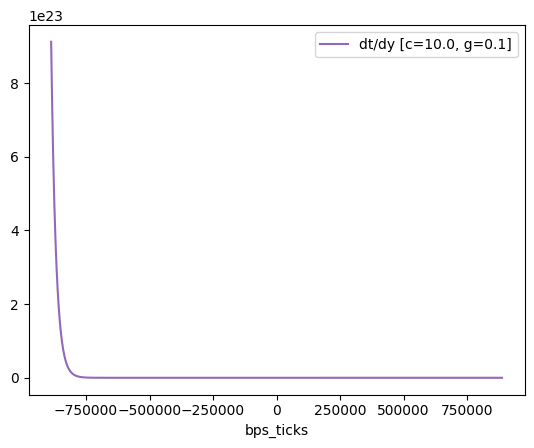

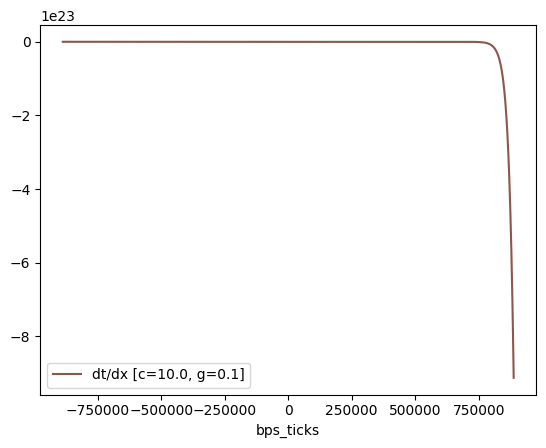

In [19]:
# plot y and x slippage across all ticks
df.plot(x='bps_ticks', y=f'dt/dy [c={C}, g={GAMMA}]', color='C4')
df.plot(x='bps_ticks', y=f'dt/dx [c={C}, g={GAMMA}]', color='C5')

In [20]:
df[f'dt/dy [c={C}, g={GAMMA}]']

0         9.123342e+23
1         9.118576e+23
2         9.113813e+23
3         9.109052e+23
4         9.104293e+23
              ...     
177450    2.686949e-15
177451    2.685667e-15
177452    2.684385e-15
177453    2.683104e-15
177454    2.681823e-15
Name: dt/dy [c=10.0, g=0.1], Length: 177455, dtype: float64

In [21]:
# if pool is 10 bps away from p=1, and swap in 10% of liquidity in y
# should expect tick to increase by ~6% to 10.63 bps away
(0.1 * clp.c) * clp.slip_y(from_bps_tick(10))

0.06280672598454913

<Axes: xlabel='bps_ticks'>

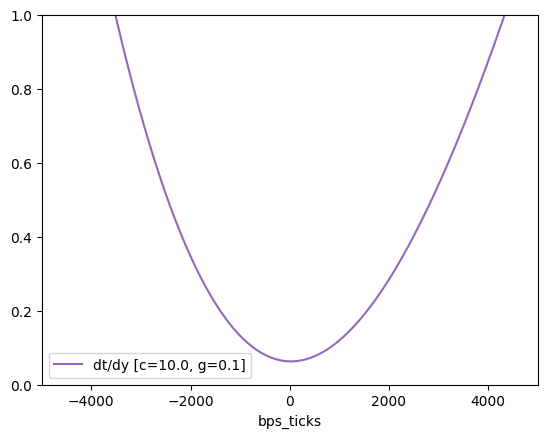

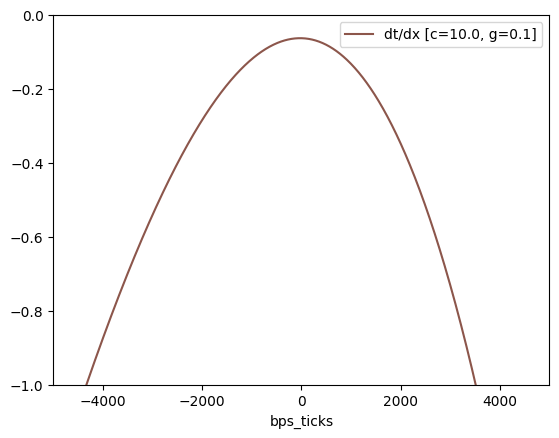

In [22]:
# plot y and x slippage across near tick=0 to +/-50%
# slippage accelerates as move toward price extremes, but bottoms as approach tick=0
df.plot(x='bps_ticks', y=f'dt/dy [c={C}, g={GAMMA}]', color='C4', xlim=(-5000, 5000), ylim=(0, 1.0))
df.plot(x='bps_ticks', y=f'dt/dx [c={C}, g={GAMMA}]', color='C5', xlim=(-5000, 5000), ylim=(-1.0, 0))

<Axes: xlabel='bps_ticks'>

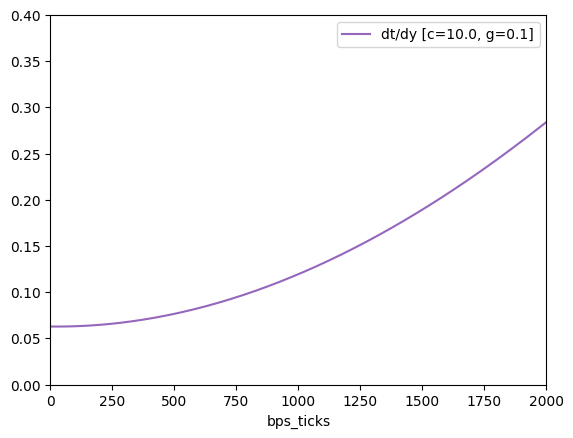

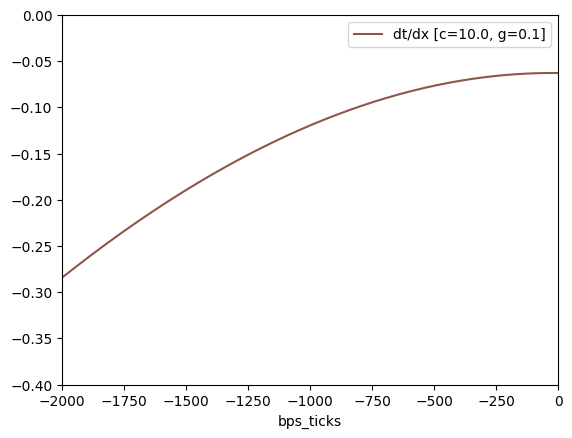

In [23]:
# plot y and x slippage from tick=0 to +/-20%
df.plot(x='bps_ticks', y=f'dt/dy [c={C}, g={GAMMA}]', color='C4', xlim=(0, 2000), ylim=(0, 0.4))
df.plot(x='bps_ticks', y=f'dt/dx [c={C}, g={GAMMA}]', color='C5', xlim=(-2000, 0), ylim=(-0.4, 0))

In [24]:
# look at slippage curves for different gamma values
for g in gammas:
    df[f'dt/dy [c={C}, g={g}]'] = CauchyLiquidityProfile(c=C, gamma=g).slip_y(log_ticks)
    df[f'dt/dx [c={C}, g={g}]'] = CauchyLiquidityProfile(c=C, gamma=g).slip_x(log_ticks)

In [25]:
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]","l(t) [c=10.0, g=0.0125]","l(t) [c=10.0, g=0.025]","l(t) [c=10.0, g=0.05]","l(t) [c=10.0, g=0.2]","l(t) [c=10.0, g=0.5]","l(t) [c=10.0, g=1.0]","l(t) [c=1.0, g=0.1]",...,"dt/dy [c=10.0, g=0.025]","dt/dx [c=10.0, g=0.025]","dt/dy [c=10.0, g=0.05]","dt/dx [c=10.0, g=0.05]","dt/dy [c=10.0, g=0.2]","dt/dx [c=10.0, g=0.2]","dt/dy [c=10.0, g=0.5]","dt/dx [c=10.0, g=0.5]","dt/dy [c=10.0, g=1.0]","dt/dx [c=10.0, g=1.0]"
0,-887272,-88.722764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,3.649332e+24,-1.072523e-14,1.824667e+24,-5.362616e-15,4.561688e+23,-1.340660e-15,1.824724e+23,-5.362785e-16,9.124489e+22,-2.681648e-16
1,-887262,-88.721764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,3.647426e+24,-1.073035e-14,1.823713e+24,-5.365177e-15,4.559305e+23,-1.341301e-15,1.823771e+23,-5.365346e-16,9.119723e+22,-2.682929e-16
2,-887252,-88.720764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,3.645521e+24,-1.073548e-14,1.822761e+24,-5.367739e-15,4.556924e+23,-1.341941e-15,1.822818e+23,-5.367908e-16,9.114959e+22,-2.684210e-16
3,-887242,-88.719764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,3.643616e+24,-1.074060e-14,1.821809e+24,-5.370303e-15,4.554543e+23,-1.342582e-15,1.821866e+23,-5.370472e-16,9.110197e+22,-2.685492e-16
4,-887232,-88.718764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,3.641713e+24,-1.074573e-14,1.820857e+24,-5.372867e-15,4.552164e+23,-1.343223e-15,1.820914e+23,-5.373036e-16,9.105438e+22,-2.686774e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177450,887228,88.718364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,1.074778e-14,-3.640952e+24,5.373893e-15,-1.820476e+24,1.343480e-15,-4.551213e+23,5.374062e-16,-1.820534e+23,2.687287e-16,-9.103536e+22
177451,887238,88.719364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,1.074265e-14,-3.642855e+24,5.371328e-15,-1.821428e+24,1.342839e-15,-4.553591e+23,5.371497e-16,-1.821485e+23,2.686005e-16,-9.108293e+22
177452,887248,88.720364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,1.073753e-14,-3.644759e+24,5.368765e-15,-1.822380e+24,1.342198e-15,-4.555971e+23,5.368933e-16,-1.822437e+23,2.684722e-16,-9.113054e+22
177453,887258,88.721364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,1.073240e-14,-3.646664e+24,5.366202e-15,-1.823332e+24,1.341557e-15,-4.558353e+23,5.366371e-16,-1.823390e+23,2.683441e-16,-9.117817e+22


<Axes: xlabel='bps_ticks'>

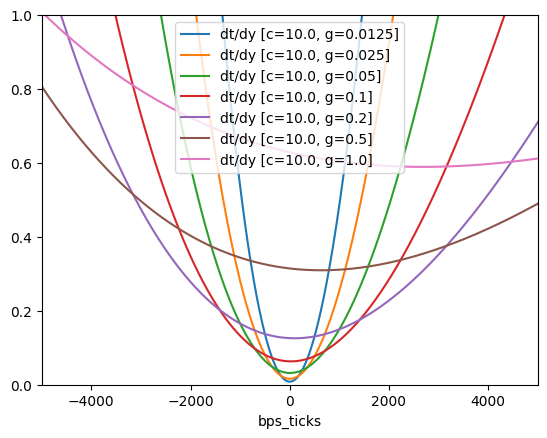

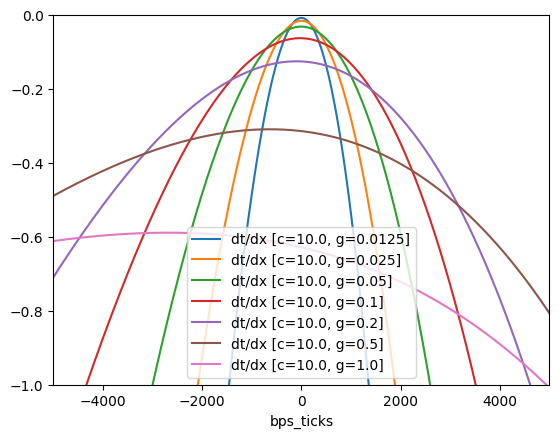

In [26]:
# plot y and x slippage across near tick=0 to +/-50% for multiple gammas
# slippage accelerates quicker at smaller tick deltas for lower gamma values (higher leverage near tick=0) 
df.plot(x='bps_ticks', y=[f'dt/dy [c={C}, g={g}]' for g in gammas], xlim=(-5000, 5000), ylim=(0, 1.0))
df.plot(x='bps_ticks', y=[f'dt/dx [c={C}, g={g}]' for g in gammas], xlim=(-5000, 5000), ylim=(-1.0, 0))

<Axes: xlabel='bps_ticks'>

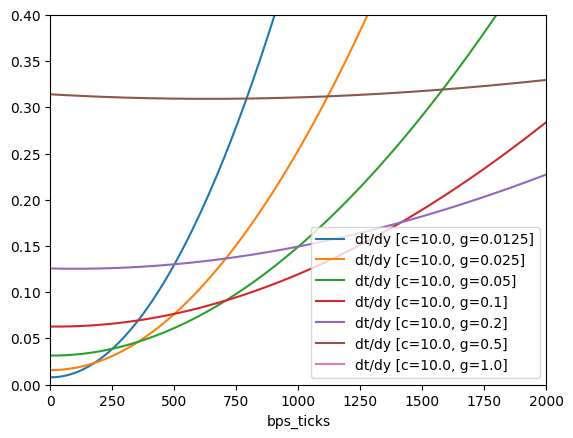

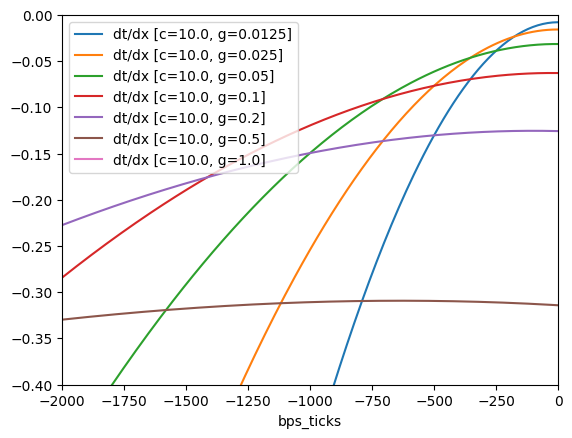

In [27]:
# plot y and x slippage from tick=0 to +/-20% for multiple gammas
# lower gamma appropriate for pairs where expect most price action within smaller tick range around tick=0
df.plot(x='bps_ticks', y=[f'dt/dy [c={C}, g={g}]' for g in gammas], xlim=(0, 2000), ylim=(0, 0.4))
df.plot(x='bps_ticks', y=[f'dt/dx [c={C}, g={g}]' for g in gammas], xlim=(-2000, 0), ylim=(-0.4, 0))

In [28]:
# look at slippage curves for different global liquidity constant values
for c in cs:
    df[f'dt/dy [c={c}, g={GAMMA}]'] = CauchyLiquidityProfile(c=c, gamma=GAMMA).slip_y(log_ticks)
    df[f'dt/dx [c={c}, g={GAMMA}]'] = CauchyLiquidityProfile(c=c, gamma=GAMMA).slip_x(log_ticks)

In [29]:
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]","l(t) [c=10.0, g=0.0125]","l(t) [c=10.0, g=0.025]","l(t) [c=10.0, g=0.05]","l(t) [c=10.0, g=0.2]","l(t) [c=10.0, g=0.5]","l(t) [c=10.0, g=1.0]","l(t) [c=1.0, g=0.1]",...,"dt/dy [c=1.0, g=0.1]","dt/dx [c=1.0, g=0.1]","dt/dy [c=2.5, g=0.1]","dt/dx [c=2.5, g=0.1]","dt/dy [c=5.0, g=0.1]","dt/dx [c=5.0, g=0.1]","dt/dy [c=20.0, g=0.1]","dt/dx [c=20.0, g=0.1]","dt/dy [c=40.0, g=0.1]","dt/dx [c=40.0, g=0.1]"
0,-887272,-88.722764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,9.123342e+24,-2.681311e-14,3.649337e+24,-1.072524e-14,1.824668e+24,-5.362621e-15,4.561671e+23,-1.340655e-15,2.280835e+23,-6.703277e-16
1,-887262,-88.721764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,9.118576e+24,-2.682591e-14,3.647430e+24,-1.073036e-14,1.823715e+24,-5.365182e-15,4.559288e+23,-1.341296e-15,2.279644e+23,-6.706478e-16
2,-887252,-88.720764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,9.113813e+24,-2.683872e-14,3.645525e+24,-1.073549e-14,1.822763e+24,-5.367745e-15,4.556906e+23,-1.341936e-15,2.278453e+23,-6.709681e-16
3,-887242,-88.719764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,9.109052e+24,-2.685154e-14,3.643621e+24,-1.074062e-14,1.821810e+24,-5.370308e-15,4.554526e+23,-1.342577e-15,2.277263e+23,-6.712885e-16
4,-887232,-88.718764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,9.104293e+24,-2.686436e-14,3.641717e+24,-1.074574e-14,1.820859e+24,-5.372872e-15,4.552147e+23,-1.343218e-15,2.276073e+23,-6.716091e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177450,887228,88.718364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,2.686949e-14,-9.102391e+24,1.074780e-14,-3.640956e+24,5.373899e-15,-1.820478e+24,1.343475e-15,-4.551195e+23,6.717373e-16,-2.275598e+23
177451,887238,88.719364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,2.685667e-14,-9.107148e+24,1.074267e-14,-3.642859e+24,5.371334e-15,-1.821430e+24,1.342833e-15,-4.553574e+23,6.714167e-16,-2.276787e+23
177452,887248,88.720364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,2.684385e-14,-9.111908e+24,1.073754e-14,-3.644763e+24,5.368770e-15,-1.822382e+24,1.342192e-15,-4.555954e+23,6.710962e-16,-2.277977e+23
177453,887258,88.721364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,2.683104e-14,-9.116670e+24,1.073241e-14,-3.646668e+24,5.366207e-15,-1.823334e+24,1.341552e-15,-4.558335e+23,6.707759e-16,-2.279168e+23


<Axes: xlabel='bps_ticks'>

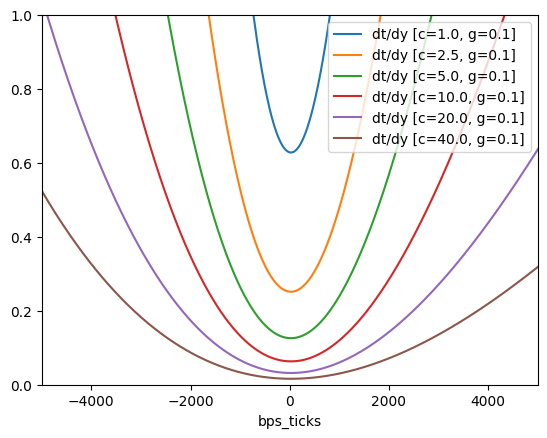

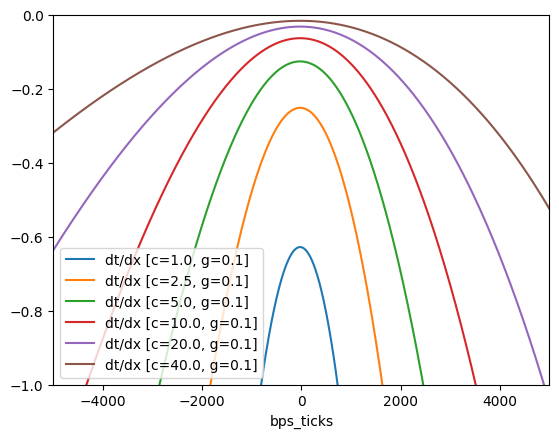

In [30]:
# plot y and x slippage across near tick=0 to +/-50% for multiple liquidity constants
# higher liquidity constant also means less slippage acceleration once moves away from tick=0 range
df.plot(x='bps_ticks', y=[f'dt/dy [c={c}, g={GAMMA}]' for c in cs], xlim=(-5000, 5000), ylim=(0, 1.0))
df.plot(x='bps_ticks', y=[f'dt/dx [c={c}, g={GAMMA}]' for c in cs], xlim=(-5000, 5000), ylim=(-1.0, 0))

<Axes: xlabel='bps_ticks'>

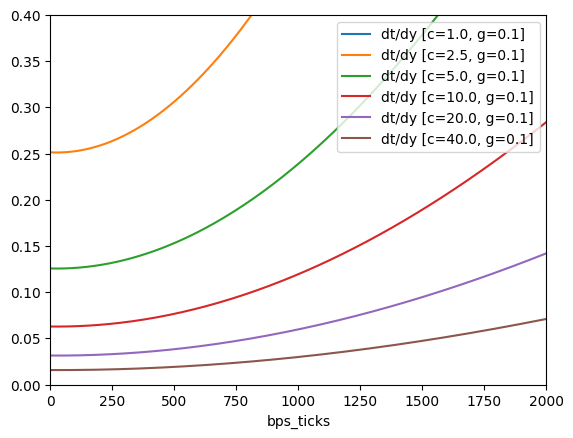

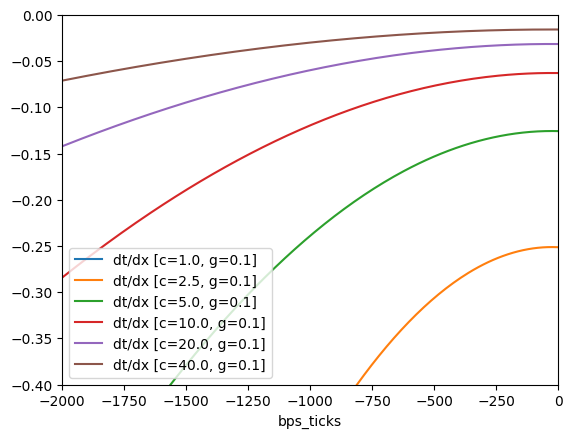

In [31]:
# plot y and x slippage from tick=0 to +/-20% for multiple liquidity constants
# more global liquidity seems to also translate to wider bottoming out of slippage near tick=0
df.plot(x='bps_ticks', y=[f'dt/dy [c={c}, g={GAMMA}]' for c in cs], xlim=(0, 2000), ylim=(0, 0.4))
df.plot(x='bps_ticks', y=[f'dt/dx [c={c}, g={GAMMA}]' for c in cs], xlim=(-2000, 0), ylim=(-0.4, 0))

In [32]:
# @dev executing this cell takes a while given the numerical integration on each tick range step

# as gamma decreases, higher leverage around tick=0 implies larger amount of capital needed to move pool price
#  ... gamma=0.0125: to move tick 0.1% higher from 0, need to swap in to pool ~1.27% of y reserves for cost leverage of 12.7x
#  ... gamma=0.1: to move tick 0.1% higher from 0, need to swap in to pool ~0.15% of y reserves for cost leverage of 1.5x

# with tradeoff that as pool price moves further away from tick=0, lower gamma results in faster drop off in
# cost of capital to move pool per unit of tick change
#  ... gamma=0.0125: to move tick 0.1% higher from tick=500 to tick=510, cost leverage of 0.75x
#  ... gamma=0.1: to move tick 0.1% higher from tick=500 to tick=510, cost leverage of 1.3x

width = 10  # bps (0.1%)
top = 600  # bps (6%)
tick_ranges = [(width * i, width * (i+1)) for i in range(top // width)]

for i, f in tick_ranges:
    for g in gammas:
        reserves_x = CauchyLiquidityProfile(c=C, gamma=g).reserves_x(from_bps_tick(i), from_bps_tick(MAX_TICK))
        reserves_y = CauchyLiquidityProfile(c=C, gamma=g).reserves_y(from_bps_tick(i), from_bps_tick(MAX_TICK))

        # x values
        cost_x = CauchyLiquidityProfile(c=C, gamma=g).cost_x(from_bps_tick(i), from_bps_tick(f))
        cost_x_rel = cost_x / reserves_x
        cost_x_lev = (cost_x_rel * 1e4) / width

        # y values
        cost_y = CauchyLiquidityProfile(c=C, gamma=g).cost_y(from_bps_tick(i), from_bps_tick(f))
        cost_y_rel = cost_y / reserves_y
        cost_y_lev = (cost_y_rel * 1e4) / width

        print(f"(i, f): ({i}, {f}); g: {g}; rx: {reserves_x}; xout per rx (bps): {cost_x_rel * 1e4}; xout per rx per dt (factor): {cost_x_lev}") 
        print(f"(i, f): ({i}, {f}); g: {g}; ry: {reserves_y}; yin per ry (bps): {cost_y_rel * 1e4}; yin per ry per dt (factor): {cost_y_lev}")
        print()

(i, f): (0, 10); g: 0.0125; rx: 2.4452623810158904; xout per rx (bps): -519.4343269957511; xout per rx per dt (factor): -51.94343269957511
(i, f): (0, 10); g: 0.0125; ry: 2.4452623810158904; yin per ry (bps): 519.693819803699; yin per ry per dt (factor): 51.969381980369896

(i, f): (0, 10); g: 0.025; rx: 2.404218933984677; xout per rx (bps): -264.57232950403755; xout per rx per dt (factor): -26.457232950403757
(i, f): (0, 10); g: 0.025; ry: 2.404218933984677; yin per ry (bps): 264.7046068663324; yin per ry per dt (factor): 26.470460686633242

(i, f): (0, 10); g: 0.05; rx: 2.3356413812258845; xout per rx (bps): -136.2246829437444; xout per rx per dt (factor): -13.622468294374439
(i, f): (0, 10); g: 0.05; ry: 2.3356413812258845; yin per ry (bps): 136.2928043674823; yin per ry per dt (factor): 13.629280436748228

(i, f): (0, 10); g: 0.1; rx: 2.2249797031249328; xout per rx (bps): -71.50712676692821; xout per rx per dt (factor): -7.150712676692821
(i, f): (0, 10); g: 0.1; ry: 2.22497970312

In [33]:
# to compare with curve, calculate the amount of x out required to move pool to tick t for various ticks
top = 20000 # bps
bps_ticks_in_ranges = np.array([width * i for i in range((top + width) // width)])
df_w_ranges = pd.DataFrame(data={
    'bps_ticks': bps_ticks_in_ranges,
    'log_ticks': from_bps_tick(bps_ticks_in_ranges),
    'price': np.exp(from_bps_tick(bps_ticks_in_ranges)),
    'price^{-1}': np.exp(-from_bps_tick(bps_ticks_in_ranges))
})

In [34]:
df_w_ranges

,bps_ticks,log_ticks,price,price^{-1}
0,0,0.0000,1.000000,1.000000
1,10,0.0010,1.001000,0.999001
2,20,0.0020,1.002002,0.998002
3,30,0.0030,1.003004,0.997005
4,40,0.0040,1.004008,0.996008
...,...,...,...,...
1996,19960,1.9959,7.358825,0.135891
1997,19970,1.9969,7.366187,0.135755
1998,19980,1.9979,7.373556,0.135620
1999,19990,1.9989,7.380933,0.135484


In [35]:
df_w_ranges[f'xout [c={clp.c}, g={clp.gamma}]'] = df_w_ranges['bps_ticks'].apply(lambda t: clp.cost_x(from_bps_tick(0), from_bps_tick(t)))
df_w_ranges[f'yin [c={clp.c}, g={clp.gamma}]'] = df_w_ranges['bps_ticks'].apply(lambda t: clp.cost_y(from_bps_tick(0), from_bps_tick(t)))
df_w_ranges[f'rx0 [c={clp.c}, g={clp.gamma}]'] = df_w_ranges['bps_ticks'].apply(lambda t: clp.reserves_x(from_bps_tick(0), from_bps_tick(MAX_TICK)))
df_w_ranges[f'ry0 [c={clp.c}, g={clp.gamma}]'] = df_w_ranges['bps_ticks'].apply(lambda t: clp.reserves_y(from_bps_tick(0), from_bps_tick(MAX_TICK)))

In [36]:
df_w_ranges[f'xout/rx0 [c={clp.c}, g={clp.gamma}]'] = df_w_ranges[f'xout [c={clp.c}, g={clp.gamma}]'] / df_w_ranges[f'rx0 [c={clp.c}, g={clp.gamma}]']
df_w_ranges[f'|xout|/rx0 [c={clp.c}, g={clp.gamma}]'] = np.abs(df_w_ranges[f'xout [c={clp.c}, g={clp.gamma}]']) / df_w_ranges[f'rx0 [c={clp.c}, g={clp.gamma}]']
df_w_ranges[f'yin/ry0 [c={clp.c}, g={clp.gamma}]'] = df_w_ranges[f'yin [c={clp.c}, g={clp.gamma}]'] / df_w_ranges[f'ry0 [c={clp.c}, g={clp.gamma}]']

In [37]:
df_w_ranges

,bps_ticks,log_ticks,price,price^{-1},"xout [c=10.0, g=0.1]","yin [c=10.0, g=0.1]","rx0 [c=10.0, g=0.1]","ry0 [c=10.0, g=0.1]","xout/rx0 [c=10.0, g=0.1]","|xout|/rx0 [c=10.0, g=0.1]","yin/ry0 [c=10.0, g=0.1]"
0,0,0.0000,1.000000,1.000000,-0.000000,0.000000,2.22498,2.22498,-0.000000,0.000000,0.000000
1,10,0.0010,1.001000,0.999001,-0.015910,0.015918,2.22498,2.22498,-0.007151,0.007151,0.007154
2,20,0.0020,1.002002,0.998002,-0.031809,0.031841,2.22498,2.22498,-0.014296,0.014296,0.014311
3,30,0.0030,1.003004,0.997005,-0.047694,0.047766,2.22498,2.22498,-0.021436,0.021436,0.021468
4,40,0.0040,1.004008,0.996008,-0.063561,0.063689,2.22498,2.22498,-0.028567,0.028567,0.028624
...,...,...,...,...,...,...,...,...,...,...,...
1996,19960,1.9959,7.358825,0.135891,-2.213120,2.703121,2.22498,2.22498,-0.994670,0.994670,1.214897
1997,19970,1.9969,7.366187,0.135755,-2.213135,2.703229,2.22498,2.22498,-0.994676,0.994676,1.214945
1998,19980,1.9979,7.373556,0.135620,-2.213149,2.703337,2.22498,2.22498,-0.994683,0.994683,1.214994
1999,19990,1.9989,7.380933,0.135484,-2.213164,2.703445,2.22498,2.22498,-0.994689,0.994689,1.215042


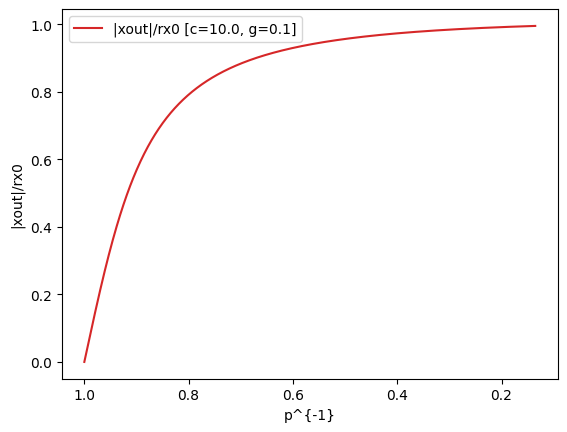

In [38]:
# plot inverse price vs x out as fraction of initial reserves
ax = df_w_ranges.plot(y=f'|xout|/rx0 [c={C}, g={GAMMA}]', x='price^{-1}', ylabel=f'|xout|/rx0', xlabel='p^{-1}', label=f'|xout|/rx0 [c={C}, g={GAMMA}]', color='C3')
ax.invert_xaxis()

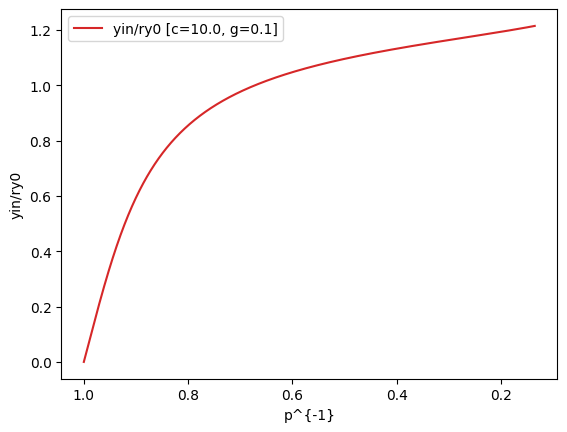

In [39]:
# plot inverse price vs y in as fraction of initial reserves
ax = df_w_ranges.plot(y=f'yin/ry0 [c={C}, g={GAMMA}]', x='price^{-1}', ylabel=f'yin/ry0', xlabel='p^{-1}', label=f'yin/ry0 [c={C}, g={GAMMA}]', color='C3')
ax.invert_xaxis()

In [40]:
# calculate relevant curve slippage quantities for different gamma values
for g in gammas:
    print(f"Calculating in/out slippage quantities for gamma: {g} ...", end='\r')

    # xout, yin and initial reserves
    df_w_ranges[f'xout [c={C}, g={g}]'] = df_w_ranges['bps_ticks'].apply(lambda t: CauchyLiquidityProfile(c=C, gamma=g).cost_x(from_bps_tick(0), from_bps_tick(t)))
    df_w_ranges[f'yin [c={C}, g={g}]'] = df_w_ranges['bps_ticks'].apply(lambda t: CauchyLiquidityProfile(c=C, gamma=g).cost_y(from_bps_tick(0), from_bps_tick(t)))
    df_w_ranges[f'rx0 [c={C}, g={g}]'] = df_w_ranges['bps_ticks'].apply(lambda t: CauchyLiquidityProfile(c=C, gamma=g).reserves_x(from_bps_tick(0), from_bps_tick(MAX_TICK)))
    df_w_ranges[f'ry0 [c={C}, g={g}]'] = df_w_ranges['bps_ticks'].apply(lambda t: CauchyLiquidityProfile(c=C, gamma=g).reserves_y(from_bps_tick(0), from_bps_tick(MAX_TICK)))

    # ratios for plotting
    df_w_ranges[f'xout/rx0 [c={C}, g={g}]'] = df_w_ranges[f'xout [c={C}, g={g}]'] / df_w_ranges[f'rx0 [c={C}, g={g}]']
    df_w_ranges[f'|xout|/rx0 [c={C}, g={g}]'] = np.abs(df_w_ranges[f'xout [c={C}, g={g}]']) / df_w_ranges[f'rx0 [c={C}, g={g}]']
    df_w_ranges[f'yin/ry0 [c={C}, g={g}]'] = df_w_ranges[f'yin [c={C}, g={g}]'] / df_w_ranges[f'ry0 [c={C}, g={g}]']

Calculating in/out slippage quantities for gamma: 1.0 ......

In [41]:
df_w_ranges

,bps_ticks,log_ticks,price,price^{-1},"xout [c=10.0, g=0.1]","yin [c=10.0, g=0.1]","rx0 [c=10.0, g=0.1]","ry0 [c=10.0, g=0.1]","xout/rx0 [c=10.0, g=0.1]","|xout|/rx0 [c=10.0, g=0.1]",...,"xout/rx0 [c=10.0, g=0.5]","|xout|/rx0 [c=10.0, g=0.5]","yin/ry0 [c=10.0, g=0.5]","xout [c=10.0, g=1.0]","yin [c=10.0, g=1.0]","rx0 [c=10.0, g=1.0]","ry0 [c=10.0, g=1.0]","xout/rx0 [c=10.0, g=1.0]","|xout|/rx0 [c=10.0, g=1.0]","yin/ry0 [c=10.0, g=1.0]"
0,0,0.0000,1.000000,1.000000,-0.000000,0.000000,2.22498,2.22498,-0.000000,0.000000,...,-0.000000,0.000000,0.000000,-0.000000,0.000000,1.369571,1.369571,-0.000000,0.000000,0.000000
1,10,0.0010,1.001000,0.999001,-0.015910,0.015918,2.22498,2.22498,-0.007151,0.007151,...,-0.001857,0.001857,0.001858,-0.001591,0.001592,1.369571,1.369571,-0.001162,0.001162,0.001162
2,20,0.0020,1.002002,0.998002,-0.031809,0.031841,2.22498,2.22498,-0.014296,0.014296,...,-0.003714,0.003714,0.003717,-0.003181,0.003185,1.369571,1.369571,-0.002323,0.002323,0.002325
3,30,0.0030,1.003004,0.997005,-0.047694,0.047766,2.22498,2.22498,-0.021436,0.021436,...,-0.005569,0.005569,0.005577,-0.004771,0.004778,1.369571,1.369571,-0.003483,0.003483,0.003489
4,40,0.0040,1.004008,0.996008,-0.063561,0.063689,2.22498,2.22498,-0.028567,0.028567,...,-0.007423,0.007423,0.007438,-0.006359,0.006372,1.369571,1.369571,-0.004643,0.004643,0.004653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,19960,1.9959,7.358825,0.135891,-2.213120,2.703121,2.22498,2.22498,-0.994670,0.994670,...,-0.966548,0.966548,1.656165,-1.265552,2.624863,1.369571,1.369571,-0.924050,0.924050,1.916558
1997,19970,1.9969,7.366187,0.135755,-2.213135,2.703229,2.22498,2.22498,-0.994676,0.994676,...,-0.966589,0.966589,1.656462,-1.265670,2.625729,1.369571,1.369571,-0.924136,0.924136,1.917191
1998,19980,1.9979,7.373556,0.135620,-2.213149,2.703337,2.22498,2.22498,-0.994683,0.994683,...,-0.966629,0.966629,1.656760,-1.265787,2.626595,1.369571,1.369571,-0.924222,0.924222,1.917823
1999,19990,1.9989,7.380933,0.135484,-2.213164,2.703445,2.22498,2.22498,-0.994689,0.994689,...,-0.966669,0.966669,1.657057,-1.265905,2.627460,1.369571,1.369571,-0.924307,0.924307,1.918455


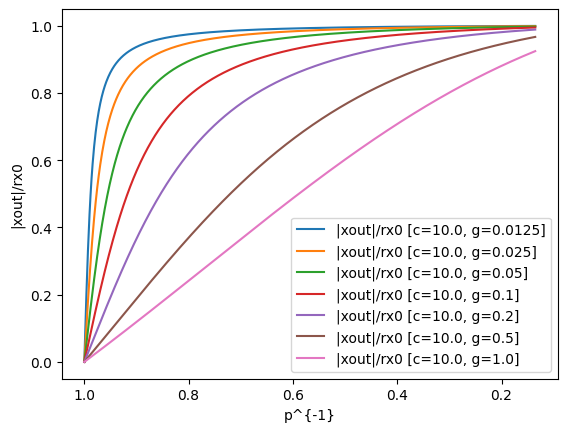

In [42]:
# plot inverse price vs x out as fraction of initial reserves for different gammas
ax = df_w_ranges.plot(x='price^{-1}', y=[f'|xout|/rx0 [c={C}, g={g}]' for g in gammas], xlabel='p^{-1}', ylabel=f'|xout|/rx0', label=[f'|xout|/rx0 [c={C}, g={g}]' for g in gammas])
ax.invert_xaxis()

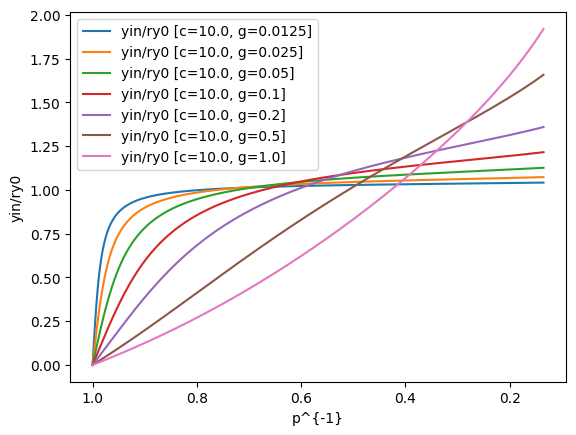

In [43]:
# plot inverse price vs y in as fraction of initial reserves for different gammas
ax = df_w_ranges.plot(x='price^{-1}', y=[f'yin/ry0 [c={C}, g={g}]' for g in gammas], xlabel='p^{-1}', ylabel=f'yin/ry0', label=[f'yin/ry0 [c={C}, g={g}]' for g in gammas])
ax.invert_xaxis()

In [44]:
# TODO: replicate reserves plot with cauchy, stableswap, and uniswap curves using lp.reserve_x, lp.reserve_y at different ticks

In [45]:
# TODO: modified cauchy liquidity profile by supplementing cauchy with base layer of full range liquidity so transitions to constant
# product in tails

In [46]:
# track progress of tick / gamma and how that relates to drop offs
df[df['bps_ticks'] > 0]['log_ticks'] / gammas[0]

88728        0.063997
88729        0.143993
88730        0.223989
88731        0.303985
88732        0.383981
             ...     
177450    7097.469132
177451    7097.549128
177452    7097.629124
177453    7097.709120
177454    7097.789116
Name: log_ticks, Length: 88727, dtype: float64

In [47]:
for g in gammas:
    df[f'log_tick / g [g={g}]'] = df['log_ticks'] / g

In [48]:
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]","l(t) [c=10.0, g=0.0125]","l(t) [c=10.0, g=0.025]","l(t) [c=10.0, g=0.05]","l(t) [c=10.0, g=0.2]","l(t) [c=10.0, g=0.5]","l(t) [c=10.0, g=1.0]","l(t) [c=1.0, g=0.1]",...,"dt/dx [c=20.0, g=0.1]","dt/dy [c=40.0, g=0.1]","dt/dx [c=40.0, g=0.1]",log_tick / g [g=0.0125],log_tick / g [g=0.025],log_tick / g [g=0.05],log_tick / g [g=0.1],log_tick / g [g=0.2],log_tick / g [g=0.5],log_tick / g [g=1.0]
0,-887272,-88.722764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,-1.340655e-15,2.280835e+23,-6.703277e-16,-7097.821115,-3548.910557,-1774.455279,-887.227639,-443.613820,-177.445528,-88.722764
1,-887262,-88.721764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,-1.341296e-15,2.279644e+23,-6.706478e-16,-7097.741119,-3548.870559,-1774.435280,-887.217640,-443.608820,-177.443528,-88.721764
2,-887252,-88.720764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,-1.341936e-15,2.278453e+23,-6.709681e-16,-7097.661123,-3548.830561,-1774.415281,-887.207640,-443.603820,-177.441528,-88.720764
3,-887242,-88.719764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,-1.342577e-15,2.277263e+23,-6.712885e-16,-7097.581127,-3548.790563,-1774.395282,-887.197641,-443.598820,-177.439528,-88.719764
4,-887232,-88.718764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,-1.343218e-15,2.276073e+23,-6.716091e-16,-7097.501131,-3548.750565,-1774.375283,-887.187641,-443.593821,-177.437528,-88.718764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177450,887228,88.718364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,-4.551195e+23,6.717373e-16,-2.275598e+23,7097.469132,3548.734566,1774.367283,887.183642,443.591821,177.436728,88.718364
177451,887238,88.719364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,-4.553574e+23,6.714167e-16,-2.276787e+23,7097.549128,3548.774564,1774.387282,887.193641,443.596821,177.438728,88.719364
177452,887248,88.720364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,-4.555954e+23,6.710962e-16,-2.277977e+23,7097.629124,3548.814562,1774.407281,887.203641,443.601820,177.440728,88.720364
177453,887258,88.721364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,-4.558335e+23,6.707759e-16,-2.279168e+23,7097.709120,3548.854560,1774.427280,887.213640,443.606820,177.442728,88.721364


<Axes: xlabel='log_ticks', ylabel='|xout|/rx0'>

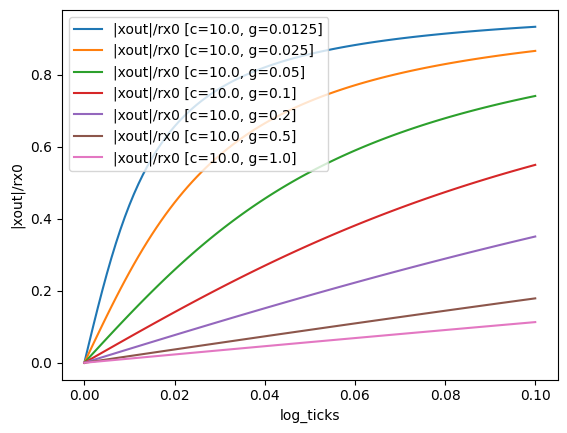

In [49]:
# at what point does x out start bending over transitioning into near infinite slippage
df_w_ranges[df_w_ranges['log_ticks'] < 0.1].plot(x='log_ticks', y=[f'|xout|/rx0 [c={C}, g={g}]' for g in gammas], xlabel='log_ticks', ylabel=f'|xout|/rx0', label=[f'|xout|/rx0 [c={C}, g={g}]' for g in gammas])

In [50]:
for g in gammas:
    df_w_ranges[f'log_ticks / g [g={g}]'] = df_w_ranges['log_ticks'] / g

In [51]:
df_w_ranges

,bps_ticks,log_ticks,price,price^{-1},"xout [c=10.0, g=0.1]","yin [c=10.0, g=0.1]","rx0 [c=10.0, g=0.1]","ry0 [c=10.0, g=0.1]","xout/rx0 [c=10.0, g=0.1]","|xout|/rx0 [c=10.0, g=0.1]",...,"xout/rx0 [c=10.0, g=1.0]","|xout|/rx0 [c=10.0, g=1.0]","yin/ry0 [c=10.0, g=1.0]",log_ticks / g [g=0.0125],log_ticks / g [g=0.025],log_ticks / g [g=0.05],log_ticks / g [g=0.1],log_ticks / g [g=0.2],log_ticks / g [g=0.5],log_ticks / g [g=1.0]
0,0,0.0000,1.000000,1.000000,-0.000000,0.000000,2.22498,2.22498,-0.000000,0.000000,...,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000
1,10,0.0010,1.001000,0.999001,-0.015910,0.015918,2.22498,2.22498,-0.007151,0.007151,...,-0.001162,0.001162,0.001162,0.079996,0.039998,0.019999,0.010000,0.005000,0.0020,0.0010
2,20,0.0020,1.002002,0.998002,-0.031809,0.031841,2.22498,2.22498,-0.014296,0.014296,...,-0.002323,0.002323,0.002325,0.159992,0.079996,0.039998,0.019999,0.010000,0.0040,0.0020
3,30,0.0030,1.003004,0.997005,-0.047694,0.047766,2.22498,2.22498,-0.021436,0.021436,...,-0.003483,0.003483,0.003489,0.239988,0.119994,0.059997,0.029999,0.014999,0.0060,0.0030
4,40,0.0040,1.004008,0.996008,-0.063561,0.063689,2.22498,2.22498,-0.028567,0.028567,...,-0.004643,0.004643,0.004653,0.319984,0.159992,0.079996,0.039998,0.019999,0.0080,0.0040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,19960,1.9959,7.358825,0.135891,-2.213120,2.703121,2.22498,2.22498,-0.994670,0.994670,...,-0.924050,0.924050,1.916558,159.672017,79.836008,39.918004,19.959002,9.979501,3.9918,1.9959
1997,19970,1.9969,7.366187,0.135755,-2.213135,2.703229,2.22498,2.22498,-0.994676,0.994676,...,-0.924136,0.924136,1.917191,159.752013,79.876006,39.938003,19.969002,9.984501,3.9938,1.9969
1998,19980,1.9979,7.373556,0.135620,-2.213149,2.703337,2.22498,2.22498,-0.994683,0.994683,...,-0.924222,0.924222,1.917823,159.832009,79.916004,39.958002,19.979001,9.989501,3.9958,1.9979
1999,19990,1.9989,7.380933,0.135484,-2.213164,2.703445,2.22498,2.22498,-0.994689,0.994689,...,-0.924307,0.924307,1.918455,159.912005,79.956002,39.978001,19.989001,9.994500,3.9978,1.9989


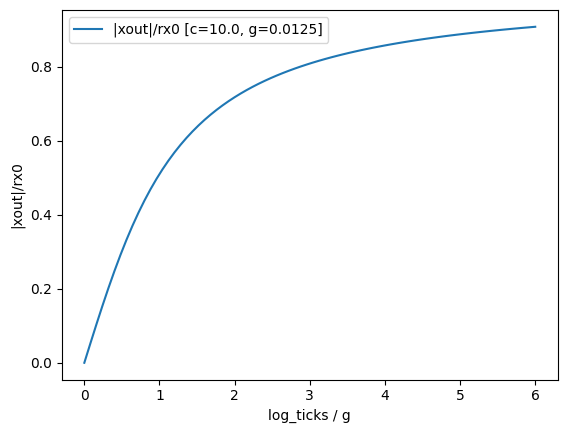

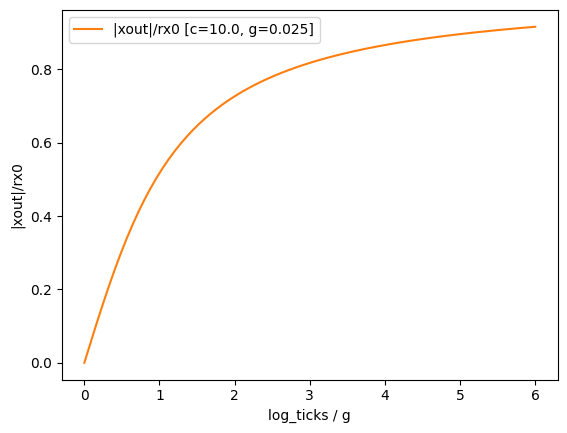

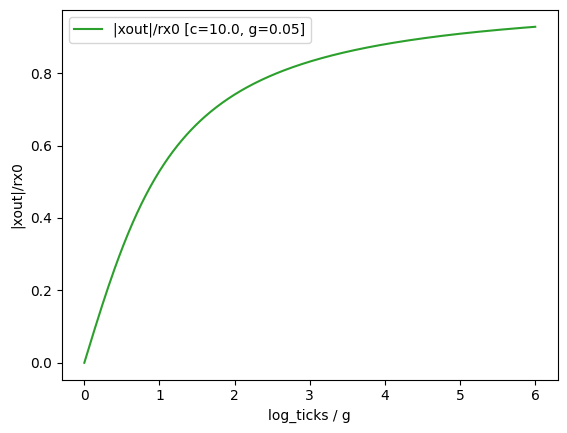

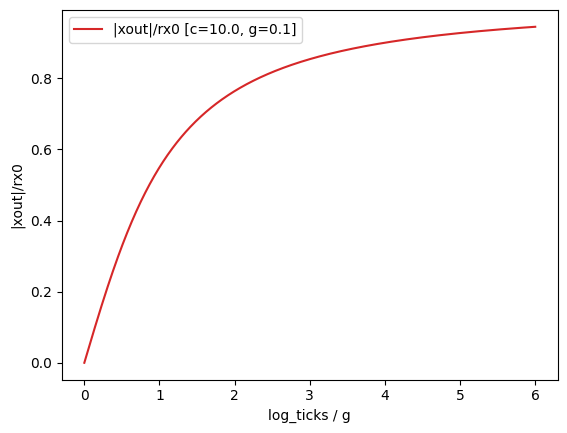

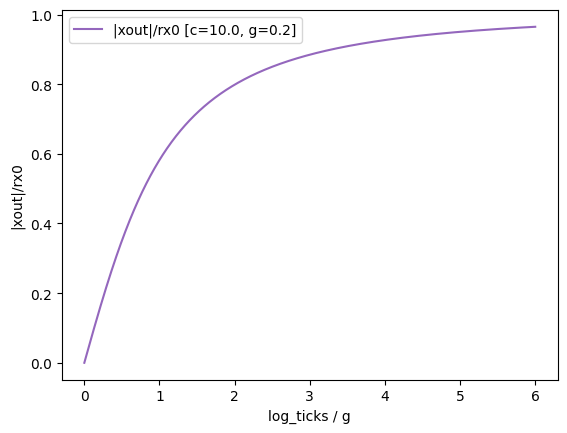

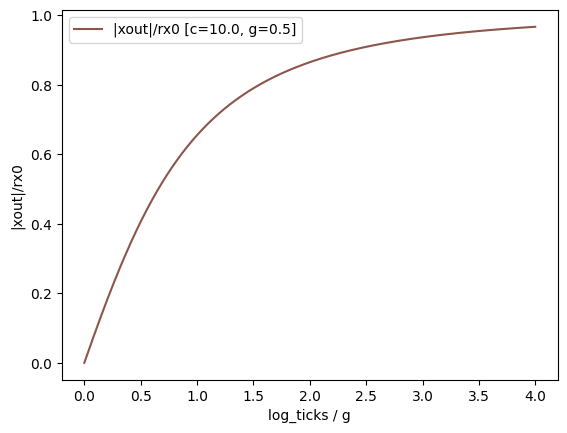

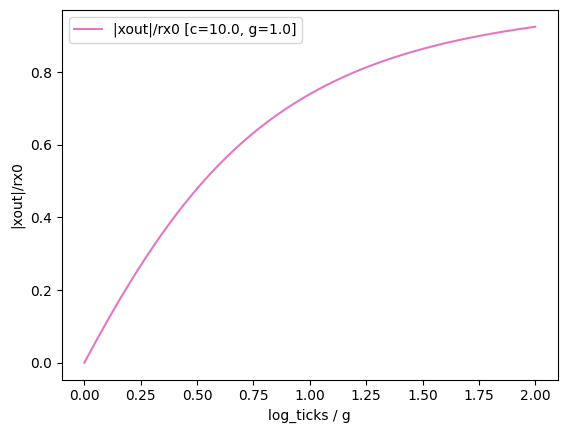

In [52]:
# plot each x out vs x axis with log ticks scaled relative to gamma g
for i, g in enumerate(gammas):
    df_w_ranges[df_w_ranges[f'log_ticks / g [g={g}]'] < 6].plot(x=f'log_ticks / g [g={g}]', y=f'|xout|/rx0 [c={C}, g={g}]', xlabel='log_ticks / g', ylabel=f'|xout|/rx0', label=f'|xout|/rx0 [c={C}, g={g}]', color=f'C{i}')

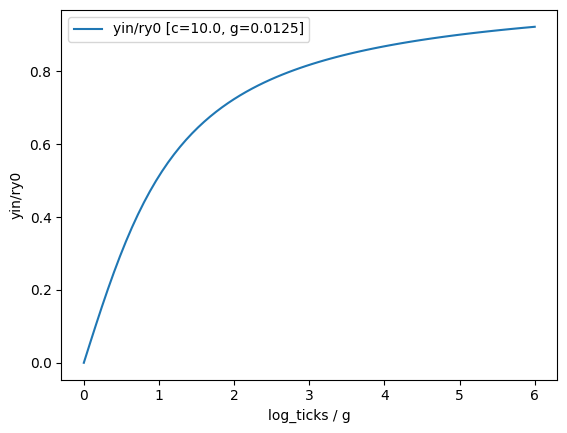

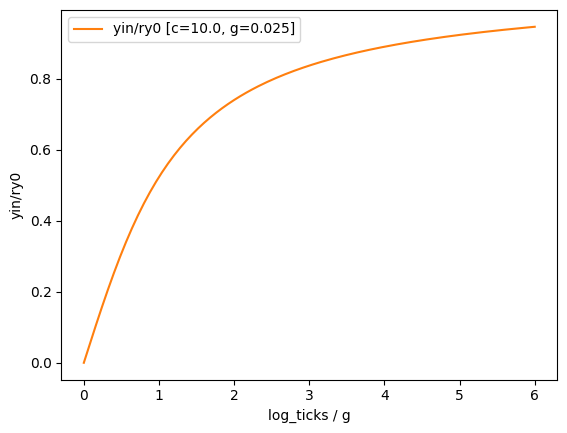

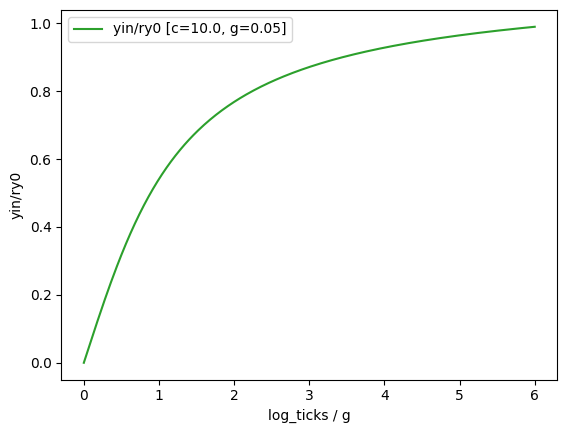

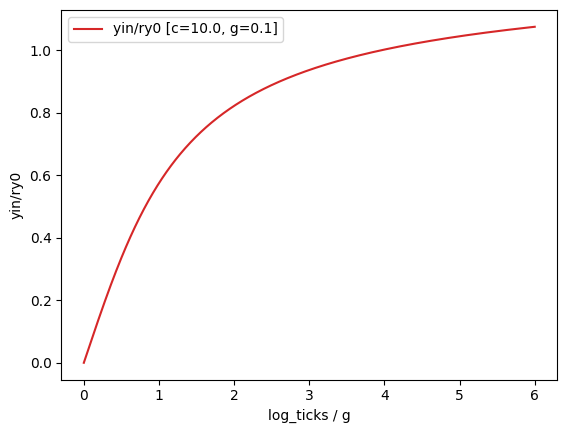

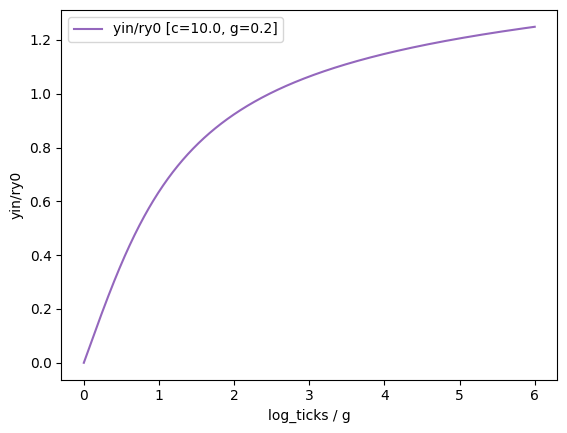

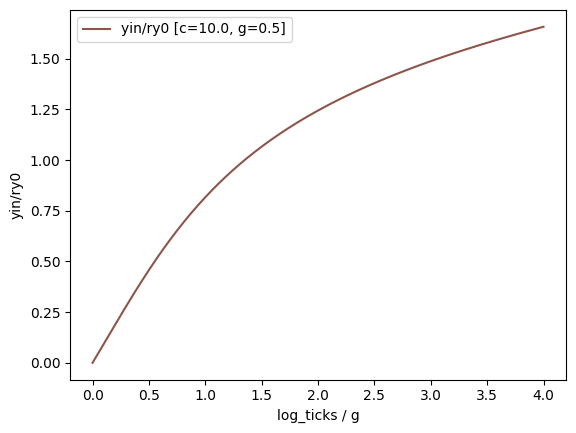

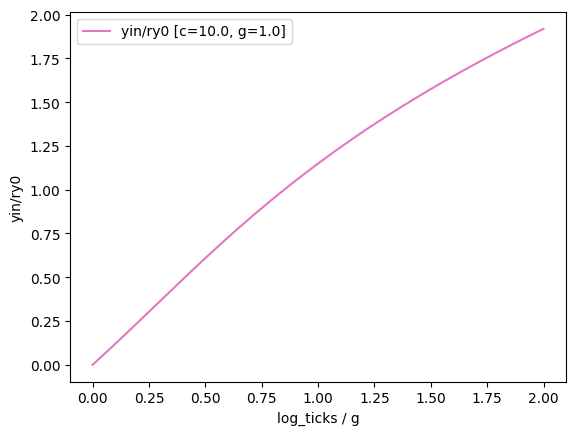

In [53]:
# plot each y in vs x axis with log ticks scaled relative to gamma g
for i, g in enumerate(gammas):
    df_w_ranges[df_w_ranges[f'log_ticks / g [g={g}]'] < 6].plot(x=f'log_ticks / g [g={g}]', y=f'yin/ry0 [c={C}, g={g}]', xlabel='log_ticks / g', ylabel=f'yin/ry0', label=f'yin/ry0 [c={C}, g={g}]', color=f'C{i}')

In [54]:
# seems like around 2 * gamma starts to break. look at slippage expressions
df_w_ranges[(df_w_ranges[f'log_ticks / g [g={gammas[0]}]'] > 1.95) & (df_w_ranges[f'log_ticks / g [g={gammas[0]}]'] < 2.05)].filter(items=[f'log_ticks / g [g={gammas[0]}]', f'|xout|/rx0 [c={C}, g={gammas[0]}]'])

,log_ticks / g [g=0.0125],"|xout|/rx0 [c=10.0, g=0.0125]"
25,1.9999,0.717335


In [55]:
df_w_ranges[(df_w_ranges[f'log_ticks / g [g={gammas[4]}]'] > 1.95) & (df_w_ranges[f'log_ticks / g [g={gammas[4]}]'] < 2.05)].filter(items=[f'log_ticks / g [g={gammas[4]}]', f'|xout|/rx0 [c={C}, g={gammas[4]}]'])

,log_ticks / g [g=0.2],"|xout|/rx0 [c=10.0, g=0.2]"
391,1.954902,0.792725
392,1.959902,0.793384
393,1.964902,0.794040
394,1.969902,0.794693
395,1.974901,0.795344
396,1.979901,0.795991
397,1.984901,0.796635
398,1.989901,0.797276
399,1.994900,0.797915
400,1.999900,0.798551


In [56]:
def modified_c(c: int, pm: int) -> float:
    return c / (1 + 1/(1 + pm**2))

In [57]:
# update to use modified cauchy liquidity profile with constant full range liquidity supplement at peg=gamma
PEG = 2 * GAMMA
MC = modified_c(C, 2)
mclp = ModifiedCauchyLiquidityProfile(c=MC, gamma=GAMMA, peg=PEG)

In [58]:
# should be mc / (pi * gamma) * (1 + 1/(1 + (peg/gamma)**2))
np.isclose(mclp.at(0), (MC / (np.pi * GAMMA)) * (1 + 1/(1 + (PEG/GAMMA)**2)))

True

In [59]:
# normalized to prior non-modified liquidity distribution to compare
np.isclose(mclp.at(0), (C / (np.pi * GAMMA)))

True

In [60]:
df[f'ml(t) [c={MC}, g={GAMMA}, peg={PEG}]'] = mclp.at(df['log_ticks'])

In [61]:
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]","l(t) [c=10.0, g=0.0125]","l(t) [c=10.0, g=0.025]","l(t) [c=10.0, g=0.05]","l(t) [c=10.0, g=0.2]","l(t) [c=10.0, g=0.5]","l(t) [c=10.0, g=1.0]","l(t) [c=1.0, g=0.1]",...,"dt/dy [c=40.0, g=0.1]","dt/dx [c=40.0, g=0.1]",log_tick / g [g=0.0125],log_tick / g [g=0.025],log_tick / g [g=0.05],log_tick / g [g=0.1],log_tick / g [g=0.2],log_tick / g [g=0.5],log_tick / g [g=1.0],"ml(t) [c=8.333333333333334, g=0.1, peg=0.2]"
0,-887272,-88.722764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,2.280835e+23,-6.703277e-16,-7097.821115,-3548.910557,-1774.455279,-887.227639,-443.613820,-177.445528,-88.722764,5.305198
1,-887262,-88.721764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,2.279644e+23,-6.706478e-16,-7097.741119,-3548.870559,-1774.435280,-887.217640,-443.608820,-177.443528,-88.721764,5.305198
2,-887252,-88.720764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,2.278453e+23,-6.709681e-16,-7097.661123,-3548.830561,-1774.415281,-887.207640,-443.603820,-177.441528,-88.720764,5.305198
3,-887242,-88.719764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,2.277263e+23,-6.712885e-16,-7097.581127,-3548.790563,-1774.395282,-887.197641,-443.598820,-177.439528,-88.719764,5.305198
4,-887232,-88.718764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,2.276073e+23,-6.716091e-16,-7097.501131,-3548.750565,-1774.375283,-887.187641,-443.593821,-177.437528,-88.718764,5.305198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177450,887228,88.718364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,6.717373e-16,-2.275598e+23,7097.469132,3548.734566,1774.367283,887.183642,443.591821,177.436728,88.718364,5.305198
177451,887238,88.719364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,6.714167e-16,-2.276787e+23,7097.549128,3548.774564,1774.387282,887.193641,443.596821,177.438728,88.719364,5.305198
177452,887248,88.720364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,6.710962e-16,-2.277977e+23,7097.629124,3548.814562,1774.407281,887.203641,443.601820,177.440728,88.720364,5.305198
177453,887258,88.721364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,6.707759e-16,-2.279168e+23,7097.709120,3548.854560,1774.427280,887.213640,443.606820,177.442728,88.721364,5.305198


<Axes: xlabel='bps_ticks'>

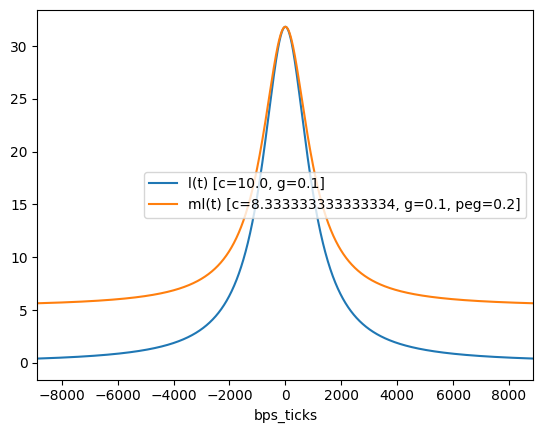

In [62]:
df.plot(x='bps_ticks', y=[f'l(t) [c={C}, g={GAMMA}]', f'ml(t) [c={MC}, g={GAMMA}, peg={PEG}]'], xlim=(-MAX_TICK // 100, MAX_TICK // 100))

In [63]:
peg_multiples = [0, 2, 4, 8, 16, 32, 64, 128]

In [64]:
%%capture
# try for various peg multiples of gamma
for g in gammas:
    for pm in peg_multiples:
        peg = pm * g
        mc = modified_c(C, pm)
        df[f'ml(t) [c={mc}, g={g}, peg={peg}]'] = ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).at(df['log_ticks'])

In [65]:
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]","l(t) [c=10.0, g=0.0125]","l(t) [c=10.0, g=0.025]","l(t) [c=10.0, g=0.05]","l(t) [c=10.0, g=0.2]","l(t) [c=10.0, g=0.5]","l(t) [c=10.0, g=1.0]","l(t) [c=1.0, g=0.1]",...,"ml(t) [c=9.997559785261103, g=0.5, peg=32.0]","ml(t) [c=9.999389722934213, g=0.5, peg=64.0]","ml(t) [c=5.0, g=1.0, peg=0.0]","ml(t) [c=8.333333333333334, g=1.0, peg=2.0]","ml(t) [c=9.444444444444445, g=1.0, peg=4.0]","ml(t) [c=9.84848484848485, g=1.0, peg=8.0]","ml(t) [c=9.96124031007752, g=1.0, peg=16.0]","ml(t) [c=9.990253411306043, g=1.0, peg=32.0]","ml(t) [c=9.997559785261103, g=1.0, peg=64.0]","ml(t) [c=9.999389722934213, g=1.0, peg=128.0]"
0,-887272,-88.722764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,0.001756,0.000591,1.591752,0.530853,0.177221,0.048627,0.01274,0.003506,0.001181,0.000599
1,-887262,-88.721764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,0.001756,0.000591,1.591752,0.530853,0.177221,0.048627,0.01274,0.003506,0.001181,0.000599
2,-887252,-88.720764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,0.001756,0.000591,1.591752,0.530853,0.177221,0.048627,0.01274,0.003506,0.001181,0.000599
3,-887242,-88.719764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,0.001756,0.000591,1.591752,0.530853,0.177221,0.048627,0.01274,0.003506,0.001181,0.000599
4,-887232,-88.718764,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,0.001756,0.000591,1.591752,0.530853,0.177221,0.048627,0.01274,0.003506,0.001181,0.000599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177450,887228,88.718364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,0.001756,0.000591,1.591752,0.530853,0.177221,0.048627,0.01274,0.003506,0.001181,0.000599
177451,887238,88.719364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,0.001756,0.000591,1.591752,0.530853,0.177221,0.048627,0.01274,0.003506,0.001181,0.000599
177452,887248,88.720364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,0.001756,0.000591,1.591752,0.530853,0.177221,0.048627,0.01274,0.003506,0.001181,0.000599
177453,887258,88.721364,0.00004,0.000005,0.00001,0.00002,0.000081,0.000202,0.000404,0.000004,...,0.001756,0.000591,1.591752,0.530853,0.177221,0.048627,0.01274,0.003506,0.001181,0.000599


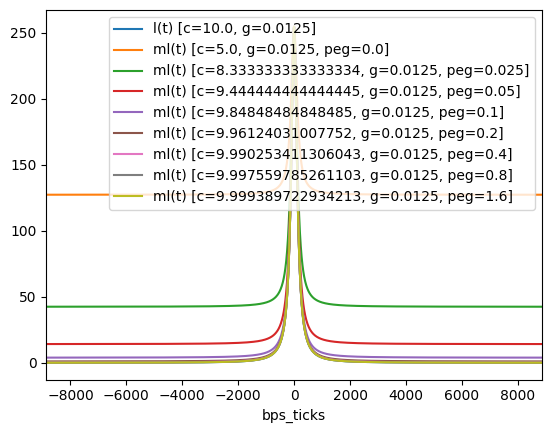

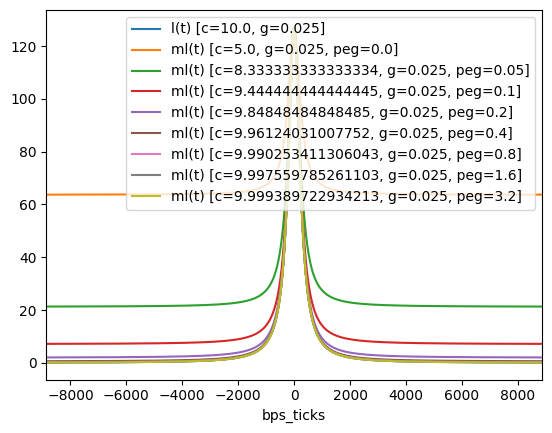

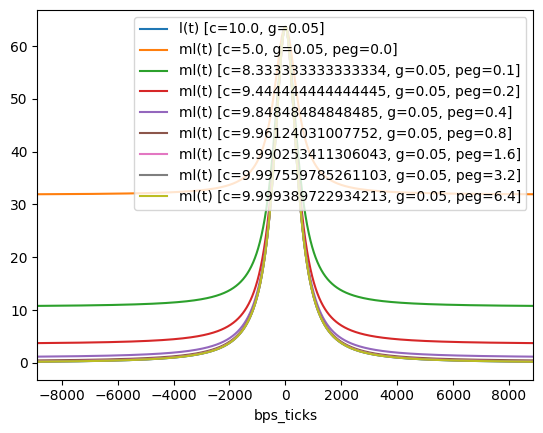

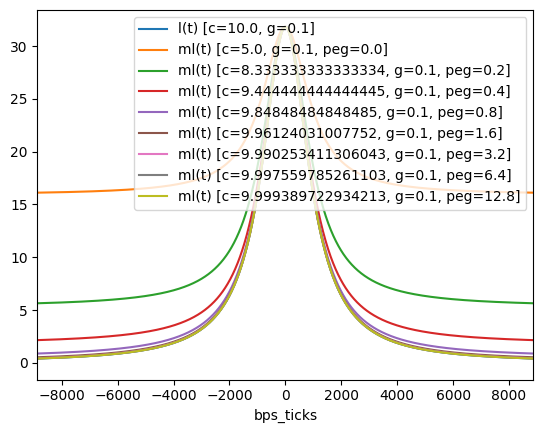

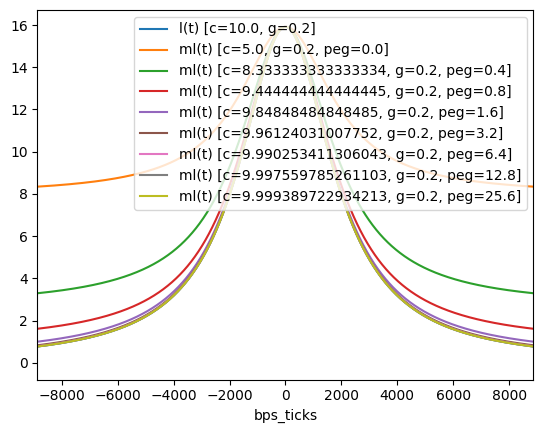

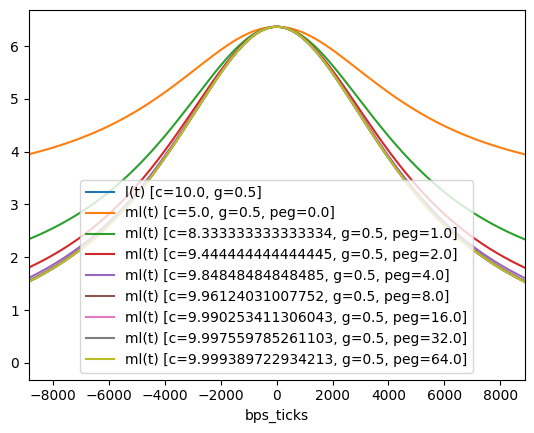

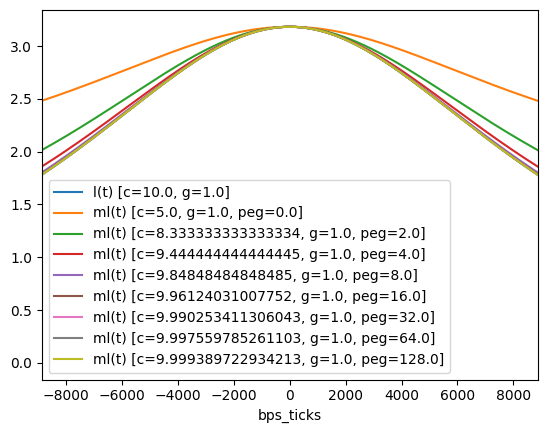

In [66]:
# plot across pegs and gammas
for g in gammas:
    ys = [f'l(t) [c={C}, g={g}]'] + [f'ml(t) [c={modified_c(C, pm)}, g={g}, peg={pm * g}]' for pm in peg_multiples]
    df.plot(x='bps_ticks', y=ys, xlim=(-MAX_TICK // 100, MAX_TICK // 100))

In [67]:
# plot slippage curves again, trying for peg. NOTE: cauchy.ppf(0.98) ~ 16 * gamma
PEG_MULTIPLE = 16

In [68]:
%%capture
# calculate relevant curve slippage quantities for different gamma values
for g in gammas:
    peg = PEG_MULTIPLE * g
    mc = modified_c(C, PEG_MULTIPLE)
    print(f"Calculating in/out slippage quantities for gamma: {g}, peg: {peg}, and mc: {mc} ...", end='\r')

    # xout, yin and initial reserves
    df_w_ranges[f'xout [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).cost_x(from_bps_tick(0), from_bps_tick(t)))
    df_w_ranges[f'yin [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).cost_y(from_bps_tick(0), from_bps_tick(t)))
    df_w_ranges[f'rx0 [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).reserves_x(from_bps_tick(0), from_bps_tick(MAX_TICK)))
    df_w_ranges[f'ry0 [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).reserves_y(from_bps_tick(0), from_bps_tick(MAX_TICK)))

    # ratios for plotting
    df_w_ranges[f'xout/rx0 [c={mc}, g={g}, peg={peg}]'] = df_w_ranges[f'xout [c={mc}, g={g}, peg={peg}]'] / df_w_ranges[f'rx0 [c={mc}, g={g}, peg={peg}]']
    df_w_ranges[f'|xout|/rx0 [c={mc}, g={g}, peg={peg}]'] = np.abs(df_w_ranges[f'xout [c={mc}, g={g}, peg={peg}]']) / df_w_ranges[f'rx0 [c={mc}, g={g}, peg={peg}]']
    df_w_ranges[f'yin/ry0 [c={mc}, g={g}, peg={peg}]'] = df_w_ranges[f'yin [c={mc}, g={g}, peg={peg}]'] / df_w_ranges[f'ry0 [c={mc}, g={g}, peg={peg}]']

In [69]:
df_w_ranges

,bps_ticks,log_ticks,price,price^{-1},"xout [c=10.0, g=0.1]","yin [c=10.0, g=0.1]","rx0 [c=10.0, g=0.1]","ry0 [c=10.0, g=0.1]","xout/rx0 [c=10.0, g=0.1]","|xout|/rx0 [c=10.0, g=0.1]",...,"xout/rx0 [c=9.96124031007752, g=0.5, peg=8.0]","|xout|/rx0 [c=9.96124031007752, g=0.5, peg=8.0]","yin/ry0 [c=9.96124031007752, g=0.5, peg=8.0]","xout [c=9.96124031007752, g=1.0, peg=16.0]","yin [c=9.96124031007752, g=1.0, peg=16.0]","rx0 [c=9.96124031007752, g=1.0, peg=16.0]","ry0 [c=9.96124031007752, g=1.0, peg=16.0]","xout/rx0 [c=9.96124031007752, g=1.0, peg=16.0]","|xout|/rx0 [c=9.96124031007752, g=1.0, peg=16.0]","yin/ry0 [c=9.96124031007752, g=1.0, peg=16.0]"
0,0,0.0000,1.000000,1.000000,-0.000000,0.000000,2.22498,2.22498,-0.000000,0.000000,...,-0.000000,0.000000,0.000000,-0.000000,0.000000,1.3766,1.3766,-0.000000,0.000000,0.000000
1,10,0.0010,1.001000,0.999001,-0.015910,0.015918,2.22498,2.22498,-0.007151,0.007151,...,-0.001838,0.001838,0.001839,-0.001591,0.001592,1.3766,1.3766,-0.001156,0.001156,0.001156
2,20,0.0020,1.002002,0.998002,-0.031809,0.031841,2.22498,2.22498,-0.014296,0.014296,...,-0.003675,0.003675,0.003679,-0.003181,0.003185,1.3766,1.3766,-0.002311,0.002311,0.002313
3,30,0.0030,1.003004,0.997005,-0.047694,0.047766,2.22498,2.22498,-0.021436,0.021436,...,-0.005511,0.005511,0.005519,-0.004771,0.004778,1.3766,1.3766,-0.003466,0.003466,0.003471
4,40,0.0040,1.004008,0.996008,-0.063561,0.063689,2.22498,2.22498,-0.028567,0.028567,...,-0.007346,0.007346,0.007361,-0.006359,0.006372,1.3766,1.3766,-0.004620,0.004620,0.004629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,19960,1.9959,7.358825,0.135891,-2.213120,2.703121,2.22498,2.22498,-0.994670,0.994670,...,-0.961771,0.961771,1.656971,-1.268436,2.635819,1.3766,1.3766,-0.921427,0.921427,1.914731
1997,19970,1.9969,7.366187,0.135755,-2.213135,2.703229,2.22498,2.22498,-0.994676,0.994676,...,-0.961814,0.961814,1.657283,-1.268556,2.636699,1.3766,1.3766,-0.921514,0.921514,1.915370
1998,19980,1.9979,7.373556,0.135620,-2.213149,2.703337,2.22498,2.22498,-0.994683,0.994683,...,-0.961856,0.961856,1.657596,-1.268675,2.637578,1.3766,1.3766,-0.921600,0.921600,1.916009
1999,19990,1.9989,7.380933,0.135484,-2.213164,2.703445,2.22498,2.22498,-0.994689,0.994689,...,-0.961899,0.961899,1.657908,-1.268794,2.638457,1.3766,1.3766,-0.921687,0.921687,1.916648


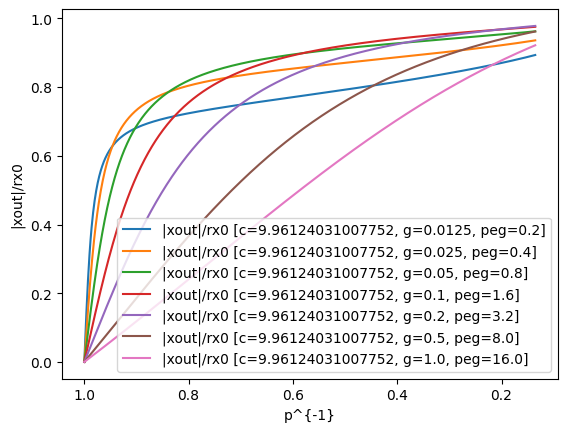

In [70]:
# for modified, plot inverse price vs x out as fraction of initial reserves for different gammas
ax = df_w_ranges.plot(x='price^{-1}', y=[f'|xout|/rx0 [c={modified_c(C, PEG_MULTIPLE)}, g={g}, peg={PEG_MULTIPLE * g}]' for g in gammas], xlabel='p^{-1}', ylabel=f'|xout|/rx0', label=[f'|xout|/rx0 [c={modified_c(C, PEG_MULTIPLE)}, g={g}, peg={PEG_MULTIPLE * g}]' for g in gammas])
ax.invert_xaxis()

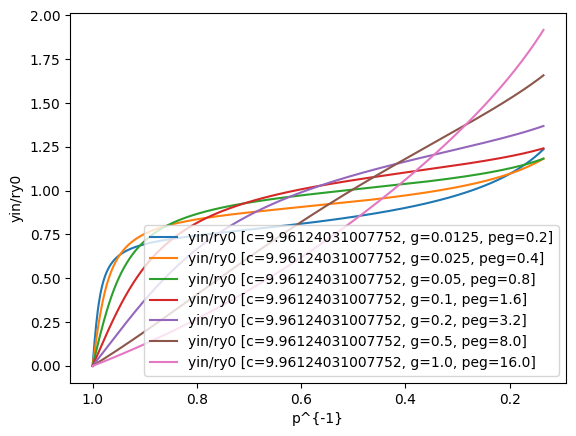

In [71]:
# for modified, plot inverse price vs y in as fraction of initial reserves for different gammas
ax = df_w_ranges.plot(x='price^{-1}', y=[f'yin/ry0 [c={modified_c(C, PEG_MULTIPLE)}, g={g}, peg={PEG_MULTIPLE * g}]' for g in gammas], xlabel='p^{-1}', ylabel=f'yin/ry0', label=[f'yin/ry0 [c={modified_c(C, PEG_MULTIPLE)}, g={g}, peg={PEG_MULTIPLE * g}]' for g in gammas])
ax.invert_xaxis()

In [72]:
%%capture
# instead plot across pegs for fixed gamma = 0.0125
for pm in peg_multiples:
    g = gammas[0]
    peg = pm * g
    mc = modified_c(C, pm)
    print(f"Calculating in/out slippage quantities for gamma: {g}, peg: {peg}, and mc: {mc} ...", end='\r')

    # xout, yin and initial reserves
    df_w_ranges[f'xout [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).cost_x(from_bps_tick(0), from_bps_tick(t)))
    df_w_ranges[f'yin [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).cost_y(from_bps_tick(0), from_bps_tick(t)))
    df_w_ranges[f'rx0 [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).reserves_x(from_bps_tick(0), from_bps_tick(MAX_TICK)))
    df_w_ranges[f'ry0 [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).reserves_y(from_bps_tick(0), from_bps_tick(MAX_TICK)))

    # ratios for plotting
    df_w_ranges[f'xout/rx0 [c={mc}, g={g}, peg={peg}]'] = df_w_ranges[f'xout [c={mc}, g={g}, peg={peg}]'] / df_w_ranges[f'rx0 [c={mc}, g={g}, peg={peg}]']
    df_w_ranges[f'|xout|/rx0 [c={mc}, g={g}, peg={peg}]'] = np.abs(df_w_ranges[f'xout [c={mc}, g={g}, peg={peg}]']) / df_w_ranges[f'rx0 [c={mc}, g={g}, peg={peg}]']
    df_w_ranges[f'yin/ry0 [c={mc}, g={g}, peg={peg}]'] = df_w_ranges[f'yin [c={mc}, g={g}, peg={peg}]'] / df_w_ranges[f'ry0 [c={mc}, g={g}, peg={peg}]']

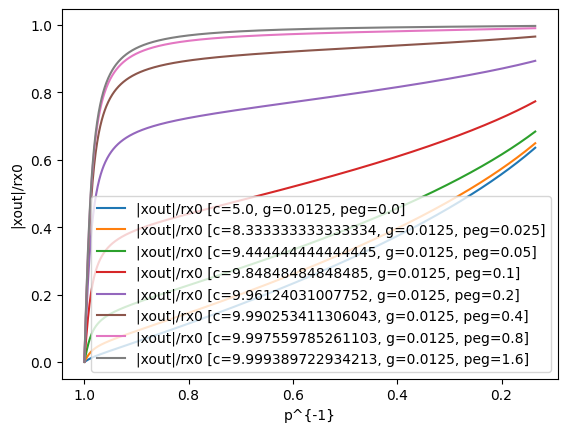

In [73]:
# for modified, plot inverse price vs x out as fraction of initial reserves for different gammas
ax = df_w_ranges.plot(x='price^{-1}', y=[f'|xout|/rx0 [c={modified_c(C, pm)}, g={gammas[0]}, peg={pm * gammas[0]}]' for pm in peg_multiples], xlabel='p^{-1}', ylabel=f'|xout|/rx0', label=[f'|xout|/rx0 [c={modified_c(C, pm)}, g={gammas[0]}, peg={pm * gammas[0]}]' for pm in peg_multiples])
ax.invert_xaxis()

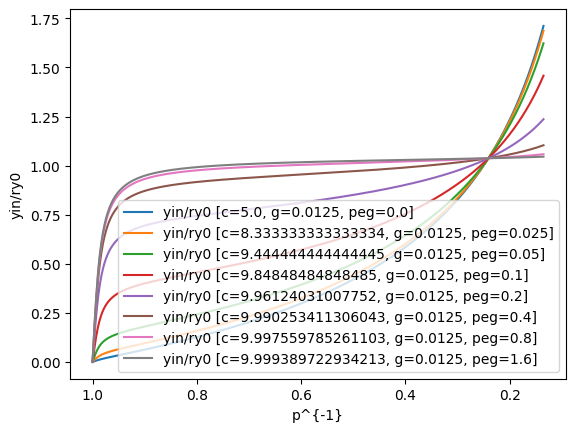

In [74]:
# for modified, plot inverse price vs y in as fraction of initial reserves for different gammas
ax = df_w_ranges.plot(x='price^{-1}', y=[f'yin/ry0 [c={modified_c(C, pm)}, g={gammas[0]}, peg={pm * gammas[0]}]' for pm in peg_multiples], xlabel='p^{-1}', ylabel=f'yin/ry0', label=[f'yin/ry0 [c={modified_c(C, pm)}, g={gammas[0]}, peg={pm * gammas[0]}]' for pm in peg_multiples])
ax.invert_xaxis()

In [78]:
%%capture
# instead plot across pegs for fixed gamma = 0.05
for pm in peg_multiples:
    g = gammas[2]
    peg = pm * g
    mc = modified_c(C, pm)
    print(f"Calculating in/out slippage quantities for gamma: {g}, peg: {peg}, and mc: {mc} ...", end='\r')

    # xout, yin and initial reserves
    df_w_ranges[f'xout [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).cost_x(from_bps_tick(0), from_bps_tick(t)))
    df_w_ranges[f'yin [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).cost_y(from_bps_tick(0), from_bps_tick(t)))
    df_w_ranges[f'rx0 [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).reserves_x(from_bps_tick(0), from_bps_tick(MAX_TICK)))
    df_w_ranges[f'ry0 [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).reserves_y(from_bps_tick(0), from_bps_tick(MAX_TICK)))

    # ratios for plotting
    df_w_ranges[f'xout/rx0 [c={mc}, g={g}, peg={peg}]'] = df_w_ranges[f'xout [c={mc}, g={g}, peg={peg}]'] / df_w_ranges[f'rx0 [c={mc}, g={g}, peg={peg}]']
    df_w_ranges[f'|xout|/rx0 [c={mc}, g={g}, peg={peg}]'] = np.abs(df_w_ranges[f'xout [c={mc}, g={g}, peg={peg}]']) / df_w_ranges[f'rx0 [c={mc}, g={g}, peg={peg}]']
    df_w_ranges[f'yin/ry0 [c={mc}, g={g}, peg={peg}]'] = df_w_ranges[f'yin [c={mc}, g={g}, peg={peg}]'] / df_w_ranges[f'ry0 [c={mc}, g={g}, peg={peg}]']

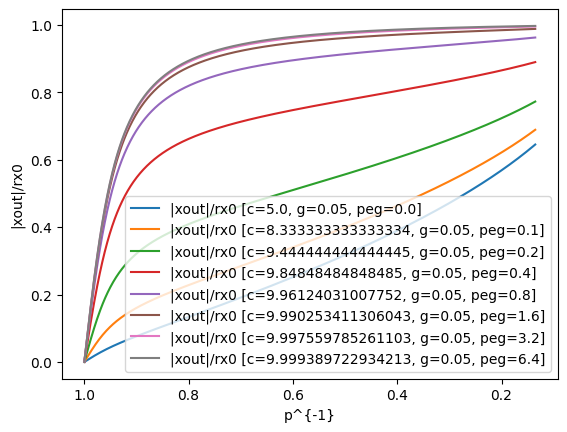

In [79]:
# for modified, plot inverse price vs x out as fraction of initial reserves for different gammas
ax = df_w_ranges.plot(x='price^{-1}', y=[f'|xout|/rx0 [c={modified_c(C, pm)}, g={gammas[2]}, peg={pm * gammas[2]}]' for pm in peg_multiples], xlabel='p^{-1}', ylabel=f'|xout|/rx0', label=[f'|xout|/rx0 [c={modified_c(C, pm)}, g={gammas[2]}, peg={pm * gammas[2]}]' for pm in peg_multiples])
ax.invert_xaxis()

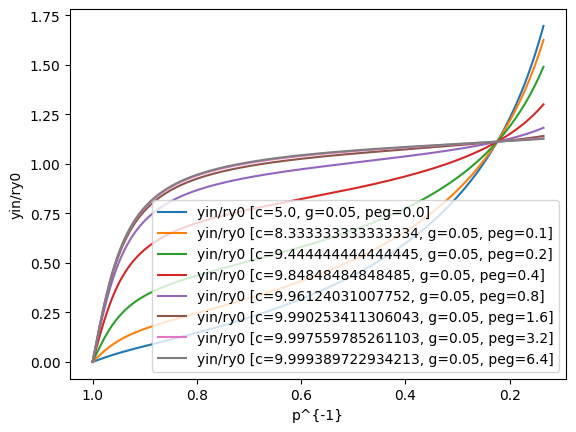

In [80]:
# for modified, plot inverse price vs y in as fraction of initial reserves for different gammas
ax = df_w_ranges.plot(x='price^{-1}', y=[f'yin/ry0 [c={modified_c(C, pm)}, g={gammas[2]}, peg={pm * gammas[2]}]' for pm in peg_multiples], xlabel='p^{-1}', ylabel=f'yin/ry0', label=[f'yin/ry0 [c={modified_c(C, pm)}, g={gammas[2]}, peg={pm * gammas[2]}]' for pm in peg_multiples])
ax.invert_xaxis()